# Lorenz system as described in Brunton et al.

A true Lorenz system is a simplified mathematical model for atmospheric convection, and is defined as the following system of ODEs:

$\dot{x} = \sigma(y-x)$ 

$\dot{y} = x(\rho - z) - y$

$\dot{z} = xy - \beta z$

Let us assume the following common parameter values: 
$\sigma = 10, \beta = 8/3, \rho = 28$

We're going to explore different regression methods that can be employed to estimate the parameters $\sigma, \beta,$ and $\rho$ from synthetic Lorenz system data. 

## Data generation via Predictor-Corrector Method

Let's start out by generating the synthetic data we want to use. 
We're going to accomplish this by 
- solving the ODE using a fourth order Runge-Kutta ODE solver and if needed, can be implemented with a predictor-corrector method with the assumed parameter values and a step size of 0.01.

The $x$, $y$, and $z$ values we get from this represent our synthetic data. 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


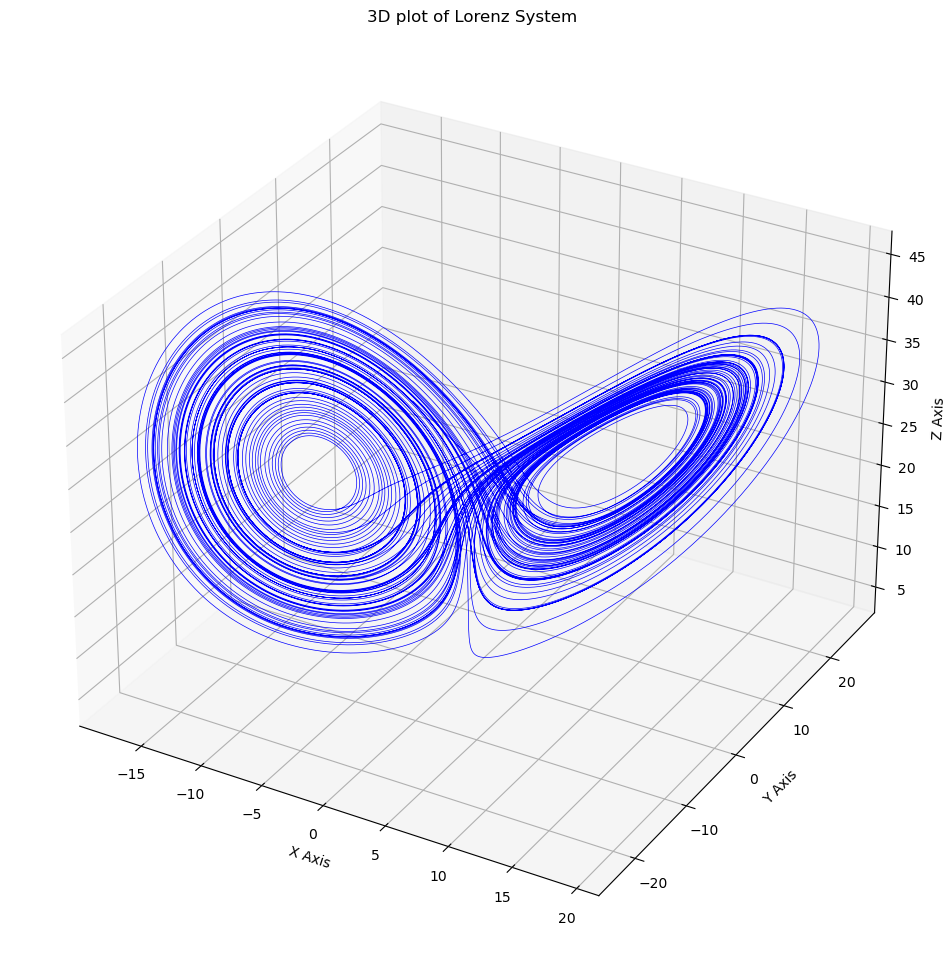

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Define the Lorenz system
def Lorenz(xyz: np.ndarray, sigma = 10, rho = 28, beta = 8/3) -> np.array:
    x, y, z = xyz
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

# Implement predictor-corrector method
# Predictor-Corrector method
def predictor_corrector(func, IC: np.ndarray, h: float, TT: float) -> np.ndarray:
    '''
    - use this for the first starting value x^hat_{n+1} to later be used for the AM3 method

    input:
    - func: ODE function we want to evaluate
    - TT: Final time of marching
    - IC: starting initial conditions
    - h: Step size

    return:
    - a multi-dimensional array of a starting data point 
    '''
    # time data settings
    time_start, time_end = 0, TT
    num_steps= int((time_end - time_start) / h)

    # Initialize trajectory data array
    trajectory_data = np.zeros((num_steps, 3))
    trajectory_data[0, :] = IC

    # Using RK4 for the first 4 points to collect data to use for the explicit AB method
    for i in range(num_steps-1):
        k1 = h * func(trajectory_data[i, :])
        k2 = h * func(trajectory_data[i, :] + 0.5 * k1)
        k3 = h * func(trajectory_data[i, :] + 0.5 * k2)
        k4 = h * func(trajectory_data[i, :] + h * k3)
        trajectory_data[i + 1, :] = trajectory_data[i, :] + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    # for more accuracy we can deploy and implement the predictor-corrector method which uses a guessing method to predict x_n+1 and then uses this value
    # in the implicit equation
    # AB4 to estimate the 5th point by using the past calculated points using RK4 (i = 0,...,4)
    trajectory_data[4, :] = trajectory_data[3, :] + (h / 24) * (55 * func(trajectory_data[3, :]) 
                            - 59 * func(trajectory_data[2, :]) + 37 * func(trajectory_data[1, :]) 
                            - 9 * func(trajectory_data[0, :]))

    # Predictor-Corrector for the remaining points
    for i in range(3, num_steps - 1):
        # Predictor (AB4) to predict the next step
        x_pred = trajectory_data[i, :] + (h / 24) * (55 * func(trajectory_data[i, :]) 
                    - 59 * func(trajectory_data[i - 1, :]) + 37 * func(trajectory_data[i - 2, :]) 
                    - 9 * func(trajectory_data[i - 3, :]))

        # Corrector (AM3) by taking the prediction and putting into the "implicit" method 
        # when its really explicit because we arent solving anything explicitly
        trajectory_data[i+1,:] = trajectory_data[i,:] + (h / 24) * (9 * func(x_pred) + 19*func(trajectory_data[i,:]) 
                                - 5*func(trajectory_data[i-1,:]) + func(trajectory_data[i-2,:]))

    return trajectory_data



# Initial conditions and time array settings
IC = np.array([-8, 8, 27])
t_start, t_end, h = 0, 100, 0.001
num_steps = int((t_end - t_start) / h)
t = np.linspace(t_start, t_end, num_steps)

# Solve the Lorenz system using RK4
trajectory_data = predictor_corrector(Lorenz, IC, h = h, TT=t_end)

# Create a 3D plot of the Lorenz system data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory_data[:, 0], trajectory_data[:, 1], trajectory_data[:, 2], lw=0.5, color="blue")
ax.set_title('3D plot of Lorenz System')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

plt.show()


## 5th order basis functions

Let us consider the dynamical system whose equations take the following form: 
$$\dot{X} = \Theta(X)\Xi$$

$\dot{X}$ is defined to be the derivatives of our system. We can compute these exactly by plugging in our synthetic data back into our system of differential equations, or numerically through a finite difference method for example. 

$\Theta(X)$ is what we call our library. Each column represents a candidate function, or basis function, for the state of our system through all time points. In this case, we are going to create a library of candidate funcitons that go up to the fifth order. This means our library will look like $1, x, y, z, x^2, xy, xz, y^2, yz, z^2, \dots$. 

Each column of $\Xi$ represents each equation in our system. The rows correspond to the basis functions in our library. This means each entry tells us the coefficient corresponding to each basis function in our system of equations. 

With these three matricies, we can apply the method of least squares to solve for $\Xi$:
$$
\xi =  \arg\min_{\xi} \left\| x - \Theta \xi \right\|_2^2
$$

This representation of a dynamical system is described in the paper by Dr. Steven Brunton and his collegues, "[Discovering governing equations from data by sparse identification of nonlinear dynamical systems](https://www.pnas.org/doi/10.1073/pnas.1517384113)." This method allows us to discover the sparsest system of governing equations for any non-linear system. Figure 1 from this paper clearly depicts how this method can be used to estimate the parameters of the Lorenz system: 

![fig 1](SINDy_Lorenz.png)

The goal of this code is to recreate the results depicted in this figure. 

The code below is from [this blog post](https://bea.stollnitz.com/blog/sindy-lorenz/) and creates our fifth order library. 

In [2]:
# Function to create library 
def create_library(u: np.ndarray, polynomial_order: int,
                   use_trig: bool) -> np.ndarray:
    """Creates a matrix containing a library of candidate functions.

    For example, if our u depends on x, y, and z, and we specify
    polynomial_order=2 and use_trig=false, our terms would be:
    1, x, y, z, x^2, xy, xz, y^2, yz, z^2.
    """
    (m, n) = u.shape
    theta = np.ones((m, 1))

    # Polynomials of order 1.
    theta = np.hstack((theta, u))

    # Polynomials of order 2.
    if polynomial_order >= 2:
        for i in range(n):
            for j in range(i, n):
                theta = np.hstack((theta, u[:, i:i + 1] * u[:, j:j + 1]))

    # Polynomials of order 3.
    if polynomial_order >= 3:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    theta = np.hstack(
                        (theta, u[:, i:i + 1] * u[:, j:j + 1] * u[:, k:k + 1]))

    # Polynomials of order 4.
    if polynomial_order >= 4:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for l in range(k, n):
                        theta = np.hstack(
                            (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                             u[:, k:k + 1] * u[:, l:l + 1]))

    # Polynomials of order 5.
    if polynomial_order >= 5:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for l in range(k, n):
                        for m in range(l, n):
                            theta = np.hstack(
                                (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                                 u[:, k:k + 1] * u[:, l:l + 1] * u[:, m:m + 1]))

    if use_trig:
        for i in range(1, 11):
            theta = np.hstack((theta, np.sin(i * u), np.cos(i * u)))

    return theta


# Now, let's generate the Theta matrix with basis functions up to order 5, without trig functions
Theta = create_library(trajectory_data, 5, False)
Theta = Theta[:-1,:]
print(Theta.shape)


(99999, 56)


## $\dot{x}$, $\dot{y}$, $\dot{z}$ computed with finite differences

The code below is a central finite difference algorithm which is used to calculate $\dot{X}$. 

In [3]:
#using central difference method to approximate x_dot, y_dot, z_dot
trajectory_deriv = np.zeros((num_steps-1, 3))
for i in range(1, num_steps-1):

    trajectory_deriv[i, :] = (trajectory_data[i+1, :] - trajectory_data[i-1, :]) / (2 * h)
print(trajectory_deriv.shape)

(99999, 3)


## OLS $\dot{x}$, $\dot{y}$, $\dot{z}$ via finite differences

In [4]:
# By using the least squares built in method, we can find our xi values
xi_LS, _, _, _ = np.linalg.lstsq(Theta, trajectory_deriv, rcond=None)
xi_LS

array([[ 1.98174122e+00, -2.01568415e-01, -1.68358560e+00],
       [-5.11763135e-01,  2.70397789e+01, -8.06251571e+00],
       [ 5.26202992e+00, -5.20030451e-01,  4.02606860e+00],
       [-7.33912853e-01,  7.46864641e-02, -2.04318513e+00],
       [-2.69125305e+00,  2.72524301e-01,  2.28650983e+00],
       [ 2.88184892e+00, -2.91791219e-01, -1.44840566e+00],
       [-2.05230456e+00, -7.92016956e-01,  1.74373457e+00],
       [-7.55840552e-01,  7.65176044e-02,  6.42191629e-01],
       [ 1.01187098e+00, -1.02610608e-01, -8.59721650e-01],
       [ 9.92390474e-02, -1.01035049e-02, -8.43058815e-02],
       [-1.91887680e-01,  1.95079448e-02,  1.63019179e-01],
       [ 3.07296714e-01, -3.12602486e-02, -2.61062347e-01],
       [ 1.96112630e-01, -1.98513818e-02, -1.66626209e-01],
       [-1.80867509e-01,  1.83994332e-02,  1.53653683e-01],
       [-1.85563719e-01,  1.87747995e-02,  1.57664734e-01],
       [ 1.66322822e-01, -1.68684522e-02, -1.41311631e-01],
       [ 3.68377079e-02, -3.74783324e-03

## Observations

We can see that performing ordinary least squares while using exact derivatives gives us the results we want (can be seen in the figure from Brunton et al.), though it is a little messy with values that are basically 0. However, ordinary least squares fails to estimate the parameters when we use finite differences. We need to apply a new regression technique to fix this. 

## Define sequential threshold least squares (STLS)

Sequential Threshold Least Squares (STLS) is a method used to fit a model to data when you have a lot of potential predictors, but only some of them might be useful. In STLS, you start by fitting the model with all the predictors. After this, the least important predictors (those with the smallest effect) are removed one by one, based on certain threshold criteria, until you're left with only the most significant predictors. This results in a more simplified model that focuses on the most influential variables.

In [5]:
def perform_SLS(Theta, xi_initial, target, threshold, max_iter):
    '''
    SLS algorithm to add sparsity to xi by using threshold and max_iter, and checks if the prior iterated xi is equal to the new xi
    params:
    - Theta: Theta matrix
    - xi_initial: xi matrix
    - target: target matrix (xyz_dot)
    - threshold: threshold value - usually 0.1
    - max_iter: maximum number of iterations - usually 100, but the algorithm will break if the prior iterated xi is equal to the new xi
    '''
    # Initialize xi and iteration count
    xi = xi_initial.copy()
    xi_prev = np.zeros_like(xi) # Store a copy of zeros with the same shape as xi
    iter_count = 0
        
    while iter_count < max_iter:
        # Store a copy of the xi from the previous iteration
        xi_prev = xi.copy()
            
        # Find small indices and update xi
        small_indices = np.abs(xi) < threshold
        xi[small_indices] = 0
            
        for dim in range(xi.shape[1]):  # Iterate through each dimension, i.e. x, y, z
            new_Theta = Theta[:, ~small_indices[:, dim]] # Remove columns that are 0'd out for the current dimension
            
            # As a saftey step, if new_Theta becomes empty, skip this iteration
            if new_Theta.shape[1] == 0:
                continue
            
            updated_values = np.linalg.lstsq(new_Theta, target[:, dim], rcond=None)[0]
            
            # Update xi with new values for the current dimension
            xi[~small_indices[:, dim], dim] = updated_values
            
        # Break the loop if the prior iterated xi is equal to the new xi
        if np.all(xi == xi_prev):
            break
                
        iter_count += 1
    return xi

## SLS with $\dot{x}$, $\dot{y}$, $\dot{z}$ via finite differences


In [6]:
# Perform SLS to add sparsity
threshold = 0.1
max_iter = 100


xi_SLS = perform_SLS(Theta, xi_LS, trajectory_deriv, threshold, max_iter)

print(xi_SLS)

[[ 0.          0.          0.        ]
 [-9.9981944  27.99716268  0.        ]
 [ 9.9983969  -0.99928688  0.        ]
 [ 0.          0.         -2.66645221]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.99994125]
 [ 0.         -0.99992752  0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.        

## Observations 

Here we can see we have the final $\Xi$ matricies are exactly how we want them. STLS cleans up the values in the exact derivative case, and gives us the coefficients we want with the finite difference case. 

In [7]:
# Define the Lorenz equations using the estimated coefficients xi
# Define the estimated Lorenz equations dynamically based on xi

def lorenz_estimated(x, xi, Theta_row):
    dxdt = np.sum(xi * Theta_row[:, np.newaxis], axis=0) # this will turn theta into a column vector, and then multiply it by xi
    return dxdt

''' For estimating the lorenz with LS data'''
# Initialize array to store results for the estimated system
trajectory_estimate = np.zeros_like(trajectory_data)
trajectory_estimate[0, :] = IC

# Solve Lorenz equations for the estimated system using Runge-Kutta method
for i in range(num_steps - 1):
    Theta_row = Theta[i, :]
    k1 = h * lorenz_estimated(trajectory_estimate[i, :], xi_LS, Theta_row)
    k2 = h * lorenz_estimated(trajectory_estimate[i, :] + 0.5 * k1, xi_LS, Theta_row)
    k3 = h * lorenz_estimated(trajectory_estimate[i, :] + 0.5 * k2, xi_LS, Theta_row)
    k4 = h * lorenz_estimated(trajectory_estimate[i, :] + h * k3, xi_LS, Theta_row)
    trajectory_estimate[i+1, :] = trajectory_estimate[i, :] + (k1 + 2 * k2 + 2 * k3 + k4) / 6

''' For estimating the lorenz with SLS data'''

#adding in a 3rd plot for sparse lorenz system
trajectory_estimate_sparse = np.zeros_like(trajectory_data)
trajectory_estimate_sparse[0, :] = IC

# Solve Lorenz equations for the estimated system using Runge-Kutta method
for i in range(num_steps - 1):
    Theta_row_sparse = Theta[i, :]
    k1 = h * lorenz_estimated(trajectory_estimate_sparse[i, :], xi_SLS, Theta_row_sparse)
    k2 = h * lorenz_estimated(trajectory_estimate_sparse[i, :] + 0.5 * k1, xi_SLS, Theta_row_sparse)
    k3 = h * lorenz_estimated(trajectory_estimate_sparse[i, :] + 0.5 * k2, xi_SLS, Theta_row_sparse)
    k4 = h * lorenz_estimated(trajectory_estimate_sparse[i, :] + h * k3, xi_SLS, Theta_row_sparse)
    trajectory_estimate_sparse[i+1, :] = trajectory_estimate_sparse[i, :] + (k1 + 2 * k2 + 2 * k3 + k4) / 6


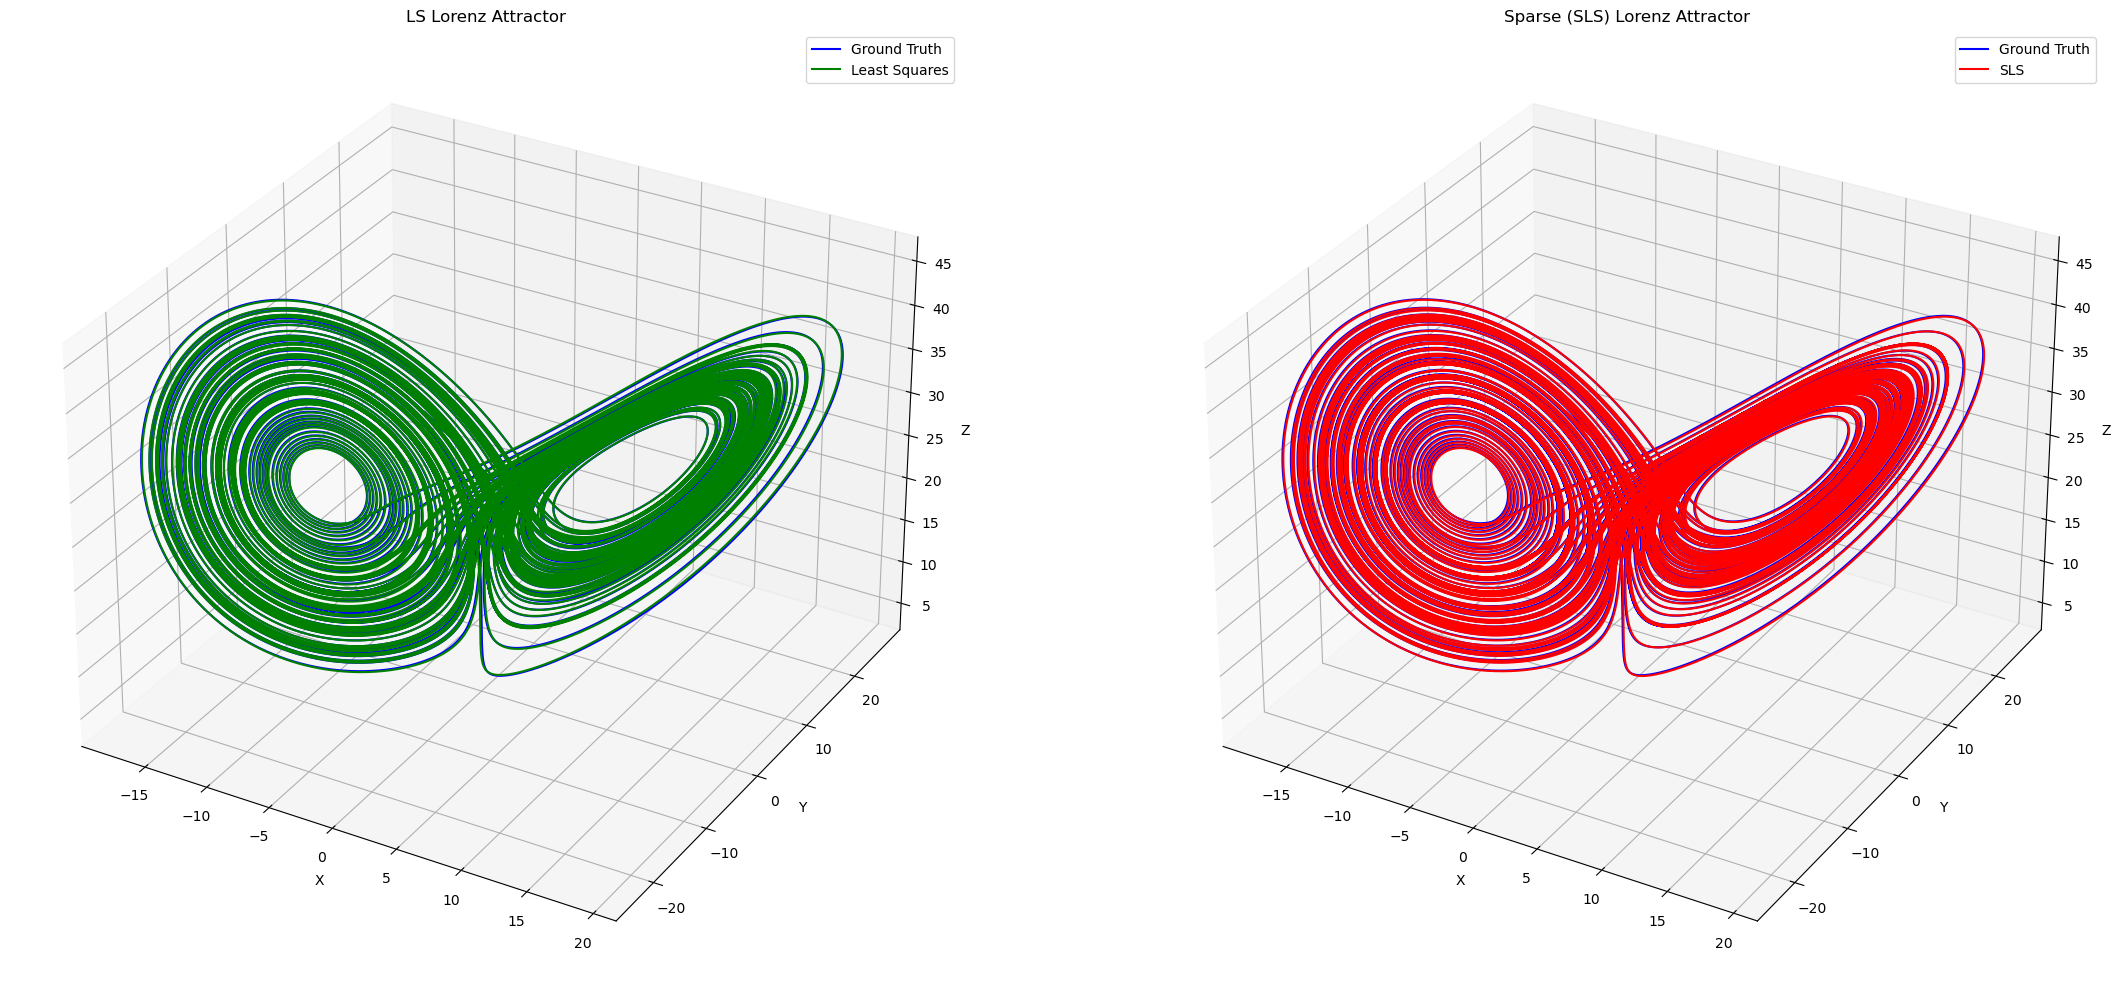

In [8]:
# Plot the original and estimated Lorenz systems for validation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

fig, axs = plt.subplots(1, 2, figsize=(27, 16), subplot_kw={'projection': '3d'})

# Plot for the estimated system on top of the original system in the right plot
axs[0].plot(trajectory_data[:, 0], trajectory_data[:, 1], trajectory_data[:, 2], color = 'Blue', label = 'Ground Truth')
axs[0].plot(trajectory_estimate[:, 0], trajectory_estimate[:, 1], trajectory_estimate[:, 2], color = 'Green', label = 'Least Squares')
axs[0].set_title("LS Lorenz Attractor")
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_zlabel('Z')
axs[0].legend()

#plot the sparse system on top of the original system
#color the sparse system
# Plot for the original system in the right plot
axs[1].plot(trajectory_data[:, 0], trajectory_data[:, 1], trajectory_data[:, 2], color='blue', label = 'Ground Truth')
axs[1].plot(trajectory_estimate_sparse[:, 0], trajectory_estimate_sparse[:, 1], trajectory_estimate_sparse[:, 2], color='red', label = 'SLS')
axs[1].set_title("Sparse (SLS) Lorenz Attractor")
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_zlabel('Z')
axs[1].legend()

plt.show()
